# Introductory Example

This notebook details a time series analysis and forecasting application performed with scalecast using the daily visitors dataset. The following concepts are covered:  

1. Exploratory Data Analysis  
2. Exponential Smoothing (usng Holt-Winters)  
3. ARIMA  
4. Multiple Linear Regression for forecasting  
5. Scikit-learn models and hyperparameter tuning  
6. Multivariate forecasting with scikit-learn models  
7. Facebook Prophet  
8. LinkedIn Greykite/Silverkite  
9. TensorFlow recurrent neural nets  
10. Native combination modeling   

The utilized dataset is available on [Kaggle](https://www.kaggle.com/datasets/bobnau/daily-website-visitors) or [RegressIt](https://regressit.com/data.html).  

## Library Imports
First, let's import the libraries and read the data. Some data preprocessing in pandas will be necessary before calling scalecast.

In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scalecast.Forecaster import Forecaster
from scalecast.MVForecaster import MVForecaster
from scalecast import GridGenerator
from scalecast.notebook import tune_test_forecast

In [2]:
# read in data
data = pd.read_csv('daily-website-visitors.csv',parse_dates = ['Date'], thousands=',')

In [3]:
# set graph sizes
sns.set(rc={'figure.figsize':(12,8)})

## Exploratory Data Analysis

Let's view the data's first five rows.

In [4]:
data.head()

,Row,Day,Day.Of.Week,Date,Page.Loads,Unique.Visits,First.Time.Visits,Returning.Visits
0,1,Sunday,1,2014-09-14,2146,1582,1430,152
1,2,Monday,2,2014-09-15,3621,2528,2297,231
2,3,Tuesday,3,2014-09-16,3698,2630,2352,278
3,4,Wednesday,4,2014-09-17,3667,2614,2327,287
4,5,Thursday,5,2014-09-18,3316,2366,2130,236


Make sure the dataset is in sequential order:

In [5]:
data = data.sort_values('Date')

A little about the series in the dataset:

In [6]:
data.drop(['Row'],axis=1).describe(include='all').T

,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
Day,2167,7,Sunday,310,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Day.Of.Week,2167.0,NaN,NaN,NaN,NaT,NaT,3.997231,2.000229,1.0,2.0,4.0,6.0,7.0
Date,2167,2167,2020-06-05 00:00:00,1,2014-09-14,2020-08-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Page.Loads,2167.0,NaN,NaN,NaN,NaT,NaT,4116.989386,1350.977843,1002.0,3114.5,4106.0,5020.5,7984.0
Unique.Visits,2167.0,NaN,NaN,NaN,NaT,NaT,2943.646516,977.886472,667.0,2226.0,2914.0,3667.5,5541.0
First.Time.Visits,2167.0,NaN,NaN,NaN,NaT,NaT,2431.824181,828.704688,522.0,1830.0,2400.0,3038.0,4616.0
Returning.Visits,2167.0,NaN,NaN,NaN,NaT,NaT,511.822335,168.73637,133.0,388.5,509.0,626.5,1036.0


Let's load the series we want to predict, Unique Visits, into a `Forecaster` object:

In [7]:
f = Forecaster(y=data['Unique.Visits'],current_dates=data['Date'])
f

Forecaster(
    DateStartActuals=2014-09-14T00:00:00.000000000
    DateEndActuals=2020-08-19T00:00:00.000000000
    Freq=D
    N_actuals=2167
    ForecastLength=0
    Xvars=[]
    Differenced=0
    TestLength=1
    ValidationLength=1
    ValidationMetric=rmse
    ForecastsEvaluated=[]
    CILevel=0.95
    BootstrapSamples=100
    CurrentEstimator=None
)

This shows we have 2,167 daily observations from 9/14/2014 through 8/19/2020 to forecast with.

The first thing we should do after initializing the object is set its test length. We can choose a number of observations to use by passing an `int` to the function below, or split the data fractionally by passing a `float` between 0 and 1.

In [8]:
f.set_test_length(.2)

Before beginning the forecasting process, we should get a better idea of the signals within the time series itself. Using ACF, PACF, and Periodogram plots, we can observe how the series is auto-correlated. We can leave the test set out of all visualizations (`train_only=True`) to not leak data when making decisions about which signals exist in the data.

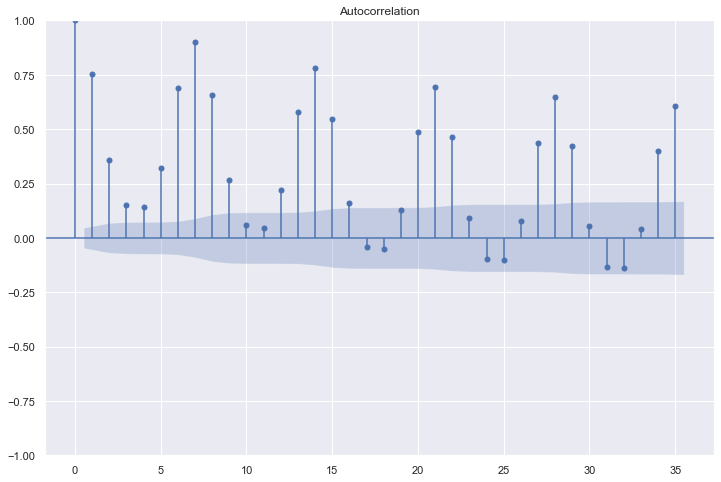

In [9]:
f.plot_acf(train_only=True,lags=35)
plt.show()

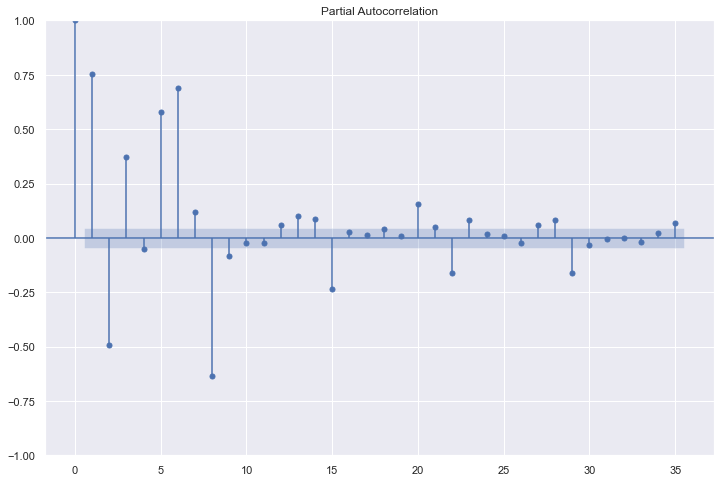

In [10]:
f.plot_pacf(train_only=True,lags=35)
plt.show()

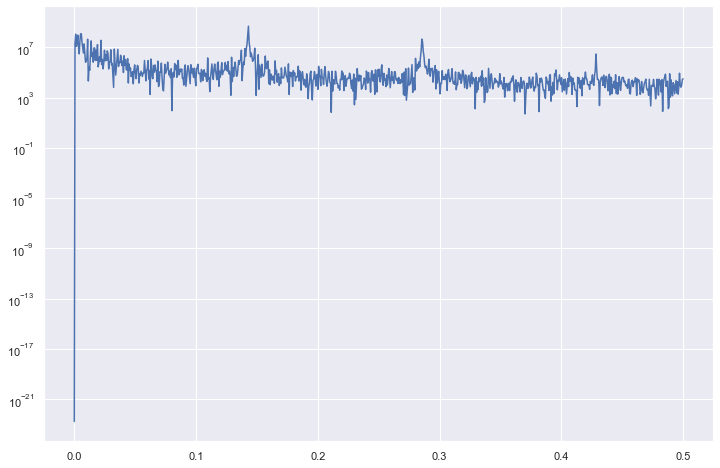

In [11]:
a, b = f.plot_periodogram(train_only=True)
plt.semilogy(a, b)
plt.show()

There might be some drift in the data.

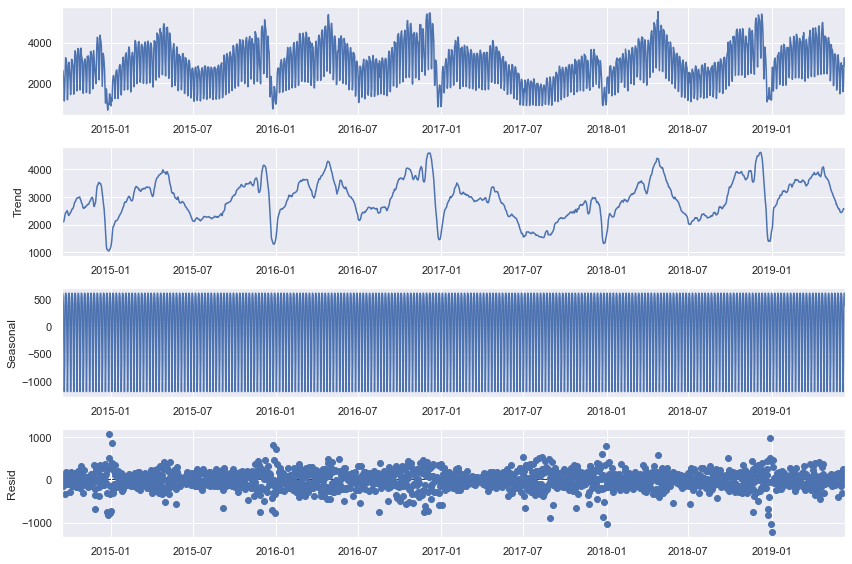

In [12]:
f.seasonal_decompose(train_only=True).plot()
plt.show()

From these graphs, we get a sense that the data exhibits several seasonalities, including yearly, weekly, monthly, and quarterly. There may be a trend in the data as well and there is definitely autoregression (the series past correlates with its future).  We can use these observations to make decisions about how to model the dataset. First, however, let's test its stationarity with an augmented dickey-fuller test. It's generally better to always model with stationary data, although it doesn't matter as much for some models.

In [13]:
critical_pval = 0.05
print('-'*100)
print('Augmented Dickey-Fuller results:')
stat, pval, _, _, _, _ = f.adf_test(full_res=True)
print('the test-stat value is: {:.2f}'.format(stat))
print('the p-value is {:.4f}'.format(pval))
print('the series is {}'.format('stationary' if pval < critical_pval else 'not stationary'))
print('-'*100)

----------------------------------------------------------------------------------------------------
Augmented Dickey-Fuller results:
the test-stat value is: -4.48
the p-value is 0.0002
the series is stationary
----------------------------------------------------------------------------------------------------


Let's now incorporate these observations as decisions in our `Forecaster` object:

In [14]:
f.generate_future_dates(60) # forecast horizon
f.set_validation_length(60) # validation set length for tuning hyperparameters
f.add_ar_terms(7) # 7 dep variable lags
f.add_AR_terms((5,7)) # 5 weekly seasonaly dep variable lags
f.add_seasonal_regressors(
    'month',
    'quarter',
    'week',
    'dayofyear',
    raw=False,
    sincos=True) # wave-form seasonality
f.add_seasonal_regressors(
    'dayofweek',
    'week',
    raw=False,
    dummy=True,
    drop_first=True
) # dummy variable seasonality
f.add_seasonal_regressors('year') # yearly trend

In [15]:
f

Forecaster(
    DateStartActuals=2014-09-14T00:00:00.000000000
    DateEndActuals=2020-08-19T00:00:00.000000000
    Freq=D
    N_actuals=2167
    ForecastLength=60
    Xvars=['AR1', 'AR2', 'AR3', 'AR4', 'AR5', 'AR6', 'AR7', 'AR14', 'AR21', 'AR28', 'AR35', 'monthsin', 'monthcos', 'quartersin', 'quartercos', 'weeksin', 'weekcos', 'dayofyearsin', 'dayofyearcos', 'dayofweek_1', 'dayofweek_2', 'dayofweek_3', 'dayofweek_4', 'dayofweek_5', 'dayofweek_6', 'week_10', 'week_11', 'week_12', 'week_13', 'week_14', 'week_15', 'week_16', 'week_17', 'week_18', 'week_19', 'week_2', 'week_20', 'week_21', 'week_22', 'week_23', 'week_24', 'week_25', 'week_26', 'week_27', 'week_28', 'week_29', 'week_3', 'week_30', 'week_31', 'week_32', 'week_33', 'week_34', 'week_35', 'week_36', 'week_37', 'week_38', 'week_39', 'week_4', 'week_40', 'week_41', 'week_42', 'week_43', 'week_44', 'week_45', 'week_46', 'week_47', 'week_48', 'week_49', 'week_5', 'week_50', 'week_51', 'week_52', 'week_53', 'week_6', 'week_7', 'wee

## Selecting which models to forecast with
The following estimators are available to us:  

1. ARIMA  
2. prophet  
3. silverkite  
4. Sklearn univariate  
5. Combo  
6. Sklearn multivariate  
7. RNN  
8. LSTM  
9. HWES  

We will briefly review each one in this order. The models that can be tuned using grid searches, we will tune. For some of these, we will use our own grids, but there are default grids from scalecast itself that we could also use. Let's get those grids.

In [16]:
GridGenerator.get_example_grids()
GridGenerator.get_mv_grids()

These functions saved a Grids.py and MVGrids.py file to the working directory. The grids in these files will automatically be read for each model class unless we pass our own grid manually.

### ARIMA

- Linear estimator speciablized for time series  
- Can be tuned with a grid search  
- By default, we can pass weekly seasonality to it but also pass other seasonality in the form of external regressors    
- Dig deeper into ARIMA with [this notebook](https://scalecast-examples.readthedocs.io/en/latest/arima/arima.html)  

In [17]:
f.set_estimator('arima')
arima_grid = {
    'order':[(1,0,1),(1,0,0),(0,0,1)],
    'seasonal_order':[(1,0,1,7),(1,0,0,7),(0,0,1,7),(0,1,0,7)],
    'Xvars':[None,['monthsin', 'monthcos', 'quartersin', 'quartercos', 'weeksin', 'weekcos', 'dayofyearsin', 'dayofyearcos']],
}

You may want to try larger grids than that in real life. By default, all grid combos will be tried, but [randomized grid-search](https://scalecast.readthedocs.io/en/latest/Forecaster/Forecaster.html#src.scalecast.Forecaster.Forecaster.limit_grid_size) is also available. If this weren't just an example, it would probably be smart to add a lot more orders to the grid.

In [18]:
f.ingest_grid(arima_grid)
f.tune()

To automatically take the best parameters chosen in the tuning process:

In [19]:
f.auto_forecast()

Test-set results:

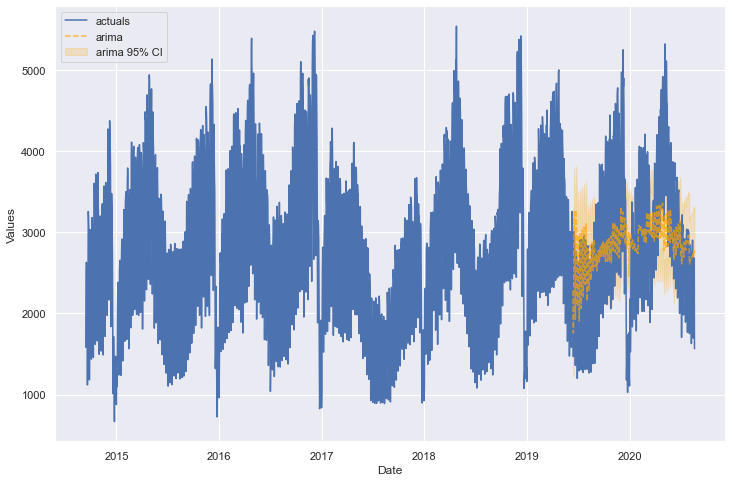

In [20]:
f.plot_test_set(ci=True,models='arima')
plt.show()

This isn't bad, but ARIMA definitely isn't capturing all the series' components that it needs to to maximize its accuracy.

If we want to see the results of the tuning process:

In [21]:
f.export_validation_grid('arima').sort_values('metric_value').head()

,order,seasonal_order,Xvars,validation_length,validation_metric,metric_value
17,"(0, 0, 1)","(1, 0, 1, 7)","[monthsin, monthcos, quartersin, quartercos, w...",60,rmse,512.882670
15,"(1, 0, 0)","(0, 1, 0, 7)","[monthsin, monthcos, quartersin, quartercos, w...",60,rmse,520.415721
2,"(1, 0, 1)","(1, 0, 0, 7)",None,60,rmse,534.937142
21,"(0, 0, 1)","(0, 0, 1, 7)","[monthsin, monthcos, quartersin, quartercos, w...",60,rmse,544.888083
4,"(1, 0, 1)","(0, 0, 1, 7)",None,60,rmse,727.171081


Model summary for ARIMA:

In [22]:
f.save_summary_stats()
f.export_summary_stats('arima')

,coef,std err,z,P>|z|,[0.025,0.975]
const,2899.0256,108.669,26.678,0.000,2686.038,3112.013
x1,854.1046,81.275,10.509,0.000,694.809,1013.401
x2,-216.9515,96.193,-2.255,0.024,-405.487,-28.416
x3,74.4654,49.010,1.519,0.129,-21.592,170.523
x4,-16.3793,51.331,-0.319,0.750,-116.987,84.228
x5,-3358.8488,557.068,-6.030,0.000,-4450.681,-2267.017
x6,-3227.8553,1321.708,-2.442,0.015,-5818.356,-637.355
x7,2669.9394,569.702,4.687,0.000,1553.344,3786.535
x8,3390.0043,1334.105,2.541,0.011,775.207,6004.802
ma.L1,0.6471,0.016,39.544,0.000,0.615,0.679


### Prophet
- Prophet is an automated forecasting procedure developed by Facebook  
- It uses the following components to predict the series in linear model:  
  - Trend  
  - Holiday effects  
  - Seasonality  
- It is capable of capturing many different kinds of seasonality  
- It attempts to identify changepoints in the series to handle non-stationary data  
- This model can be tuned in scalecast, but we will bypass that because it does a lot of tuning on itself  
- Dig deeper into Prophet with [this notebook](https://scalecast-examples.readthedocs.io/en/latest/prophet/prophet.html)  

In [23]:
f.set_estimator('prophet')
f.manual_forecast()

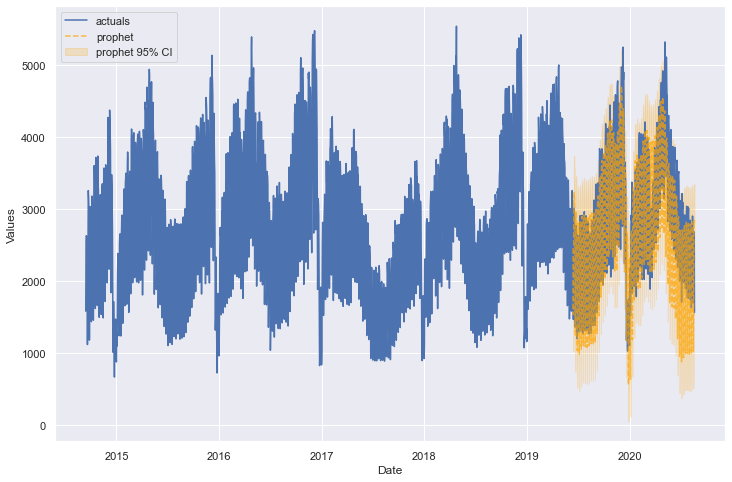

In [24]:
f.plot_test_set(ci=True,models='prophet')
plt.show()

This looks much better than ARIMA.

### Silverkite
- Silverkite is an automated forecasting procedure developed by LinkedIn and found in the greykite package  
- It uses the following components to predict the series:  
  - Trend  
  - Holiday effects  
  - Seasonality
  - AR components
- It is capable of capturing many different kinds of seasonality  
- It attempts to identify changepoints in the series to handle non-stationary data  
- This model can be tuned in scalecast, but we will bypass that because it does a lot of tuning on itself  
- Dig deeper into Silverkite with [this notebook](https://scalecast-examples.readthedocs.io/en/latest/silverkiet/silverkiet.html)  

In [25]:
f.set_estimator('silverkite')
f.manual_forecast()

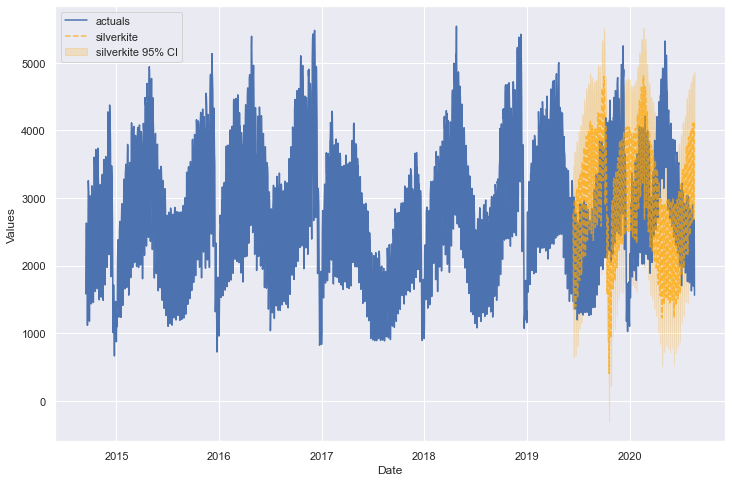

In [26]:
f.plot_test_set(ci=True,models='silverkite')
plt.show()

This does not look as good as prophet, possible better than ARIMA.

### Sklearn univariate
- Dig deeper into Sklearn estimators with [this notebook](https://scalecast-examples.readthedocs.io/en/latest/sklearn/sklearn.html)

#### MLR

In [27]:
f.set_estimator('mlr')
f.tune()
f.auto_forecast()
f.save_feature_importance()

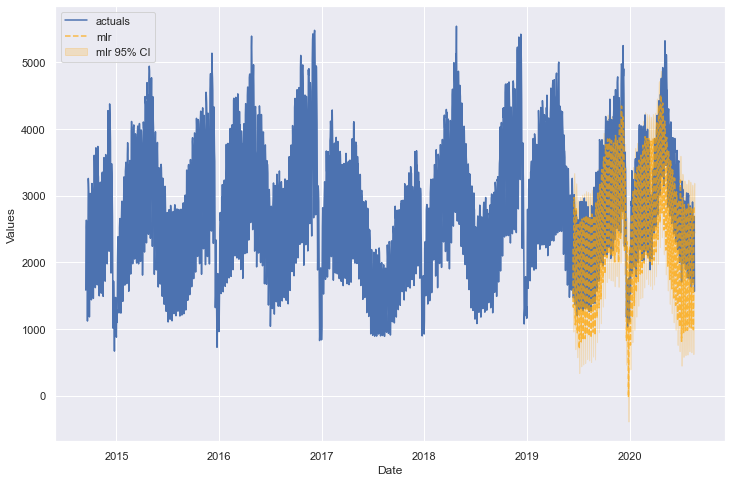

In [28]:
f.plot_test_set(ci=True,models='mlr')
plt.show()

#### XGBoost

In [29]:
f.set_estimator('xgboost')
xgboost_grid = {
     'n_estimators':[150,200,250],
     'scale_pos_weight':[5,10],
     'learning_rate':[0.1,0.2],
     'gamma':[0,3,5], 
     'subsample':[0.8,0.9]
}
f.ingest_grid(xgboost_grid)
f.tune()
f.auto_forecast()

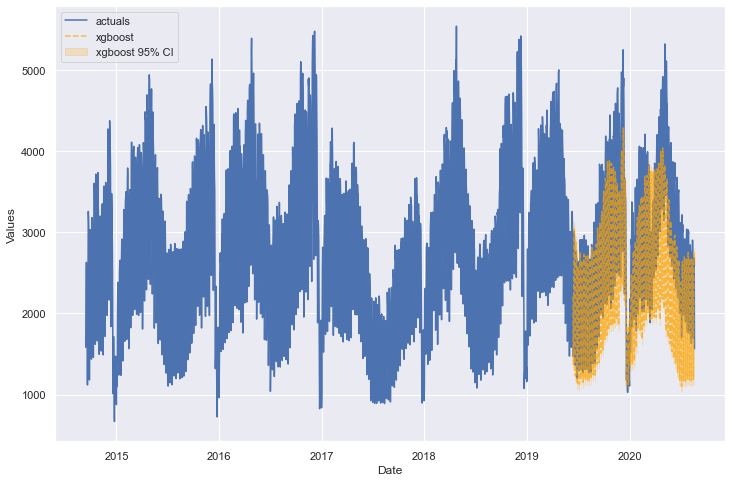

In [30]:
f.plot_test_set(ci=True,models='xgboost')
plt.show()

### Combo  
- Dig deeper into combo estimators with [this notebook](https://scalecast-examples.readthedocs.io/en/latest/combo/combo.html)

In [31]:
f.set_estimator('combo')
f.manual_forecast(how='simple',models='all',determine_best_by='TestSetMAPE',call_me='avg')
f.manual_forecast(how='weighted',models='all',determine_best_by='ValidationMetricValue',call_me='weighted')

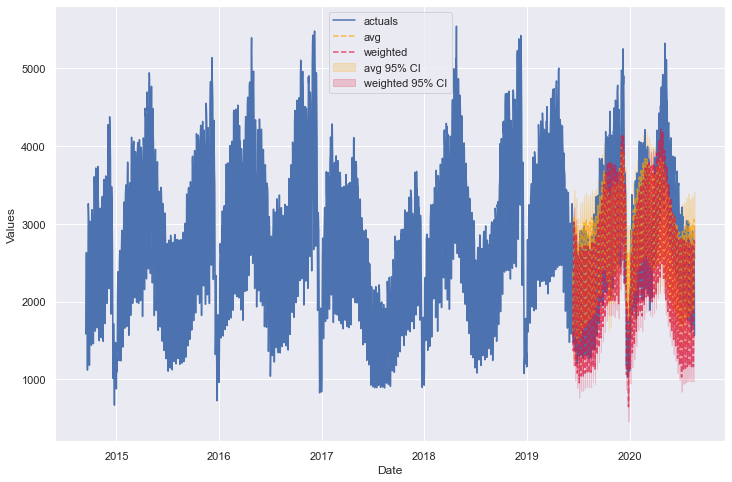

In [32]:
f.plot_test_set(ci=True,models=['avg','weighted'])
plt.show()

In [33]:
results = f.export('model_summaries',determine_best_by='TestSetMAPE')
results.columns

Index(['ModelNickname', 'Estimator', 'Xvars', 'HyperParams', 'Scaler',
       'Observations', 'Tuned', 'DynamicallyTested', 'Integration',
       'TestSetLength', 'TestSetRMSE', 'TestSetMAPE', 'TestSetMAE',
       'TestSetR2', 'LastTestSetPrediction', 'LastTestSetActual', 'CILevel',
       'CIPlusMinus', 'InSampleRMSE', 'InSampleMAPE', 'InSampleMAE',
       'InSampleR2', 'ValidationSetLength', 'ValidationMetric',
       'ValidationMetricValue', 'models', 'weights', 'LevelTestSetRMSE',
       'LevelTestSetMAPE', 'LevelTestSetMAE', 'LevelTestSetR2', 'best_model'],
      dtype='object')

In [34]:
results[['ModelNickname','TestSetMAPE','TestSetR2','InSampleMAPE','InSampleR2','best_model']]

,ModelNickname,TestSetMAPE,TestSetR2,InSampleMAPE,InSampleR2,best_model
0,prophet,0.128508,0.756013,0.098131,0.887426,True
1,weighted,0.142030,0.673586,0.035223,0.984900,False
2,mlr,0.144739,0.711367,0.060099,0.955900,False
3,avg,0.148912,0.630121,0.058152,0.959802,False
4,xgboost,0.157852,0.568095,0.010725,0.998566,False
5,arima,0.242265,0.181024,0.091892,0.897641,False
6,silverkite,0.383909,-0.711844,0.119990,0.839140,False


### Sklearn Multivariate  
- This is a method to forecast several series together, using each other's lags as inputs  
- You can use several lags from one and fewer with others, non-sequential lags, and more with this approach  
- Dig deeper into multivariate forecasting with [this notebook](https://scalecast-examples.readthedocs.io/en/latest/multivariate/multivariate.html)  

#### Prepare

In [35]:
f_dict = {c: Forecaster(
    y=data[c],
    current_dates=data['Date'],
) for c in ('Unique.Visits','Page.Loads','First.Time.Visits')}

# prepare one series only with future dates and Xvars
# all these decisions will be applied to all series when calling MVForecaster()
f_dict['Unique.Visits'].generate_future_dates(60)
f_dict['Unique.Visits'].add_seasonal_regressors(
    'month',
    'quarter',
    'week',
    'dayofyear',
    raw=False,
    sincos=True)
f_dict['Unique.Visits'].add_seasonal_regressors(
    'dayofweek',
    'week',
    raw=False,
    dummy=True,
    drop_first=True
)
f.add_seasonal_regressors('year')

# combine all series into one object
mvf = MVForecaster(*f_dict.values(),names=f_dict.keys())
# set test length
mvf.set_test_length(.2) 
# set validation length
mvf.set_validation_length(60)

Even though we are now forecasting three series together, we might still want to optimize our models based on which one best predicts unique visits.

In [36]:
mvf.set_optimize_on('Unique.Visits')

By default, models are optimized based on the average error or accuracy metrics across all series. But in the above method, we can add our own weighted average or choose one series to consider above the others.

In [37]:
mvf

MVForecaster(
    DateStartActuals=2014-09-14T00:00:00.000000000
    DateEndActuals=2020-08-19T00:00:00.000000000
    Freq=D
    N_actuals=2167
    N_series=3
    SeriesNames=['Unique.Visits', 'Page.Loads', 'First.Time.Visits']
    ForecastLength=60
    Xvars=['monthsin', 'monthcos', 'quartersin', 'quartercos', 'weeksin', 'weekcos', 'dayofyearsin', 'dayofyearcos', 'dayofweek_1', 'dayofweek_2', 'dayofweek_3', 'dayofweek_4', 'dayofweek_5', 'dayofweek_6', 'week_10', 'week_11', 'week_12', 'week_13', 'week_14', 'week_15', 'week_16', 'week_17', 'week_18', 'week_19', 'week_2', 'week_20', 'week_21', 'week_22', 'week_23', 'week_24', 'week_25', 'week_26', 'week_27', 'week_28', 'week_29', 'week_3', 'week_30', 'week_31', 'week_32', 'week_33', 'week_34', 'week_35', 'week_36', 'week_37', 'week_38', 'week_39', 'week_4', 'week_40', 'week_41', 'week_42', 'week_43', 'week_44', 'week_45', 'week_46', 'week_47', 'week_48', 'week_49', 'week_5', 'week_50', 'week_51', 'week_52', 'week_53', 'week_6', 'week_7',

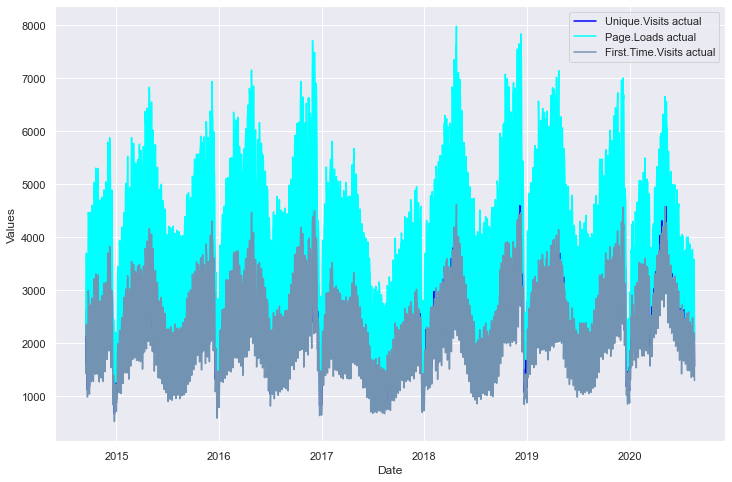

In [38]:
mvf.plot()
plt.show()

#### MLR

In [39]:
mvf.set_estimator('mlr')
mvf.manual_forecast(lags=7)

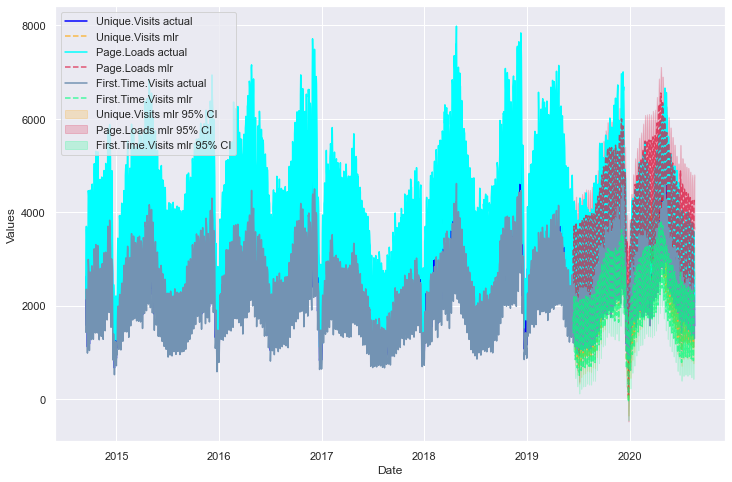

In [40]:
mvf.plot_test_set(ci=True)
plt.show()

#### GradientBoosting

In [41]:
mvf.set_estimator('gbt')
gbt_grid = {
    'learning_rate':[0.01,0.001,0.1],
    'n_estimators':[100,200,300,400,500],
    'subsample':[1.0,.5,.25],
    'max_depth':[1,2,3,10],
    'max_features':['sqrt','log2','auto',.5],
    'lags':[1,7,list(range(1,8)) + [14,21,28,35]],
}
mvf.ingest_grid(gbt_grid)
# randomized grid search to limit iters to 50
mvf.limit_grid_size(50,random_seed=20)
mvf.tune()
mvf.auto_forecast()

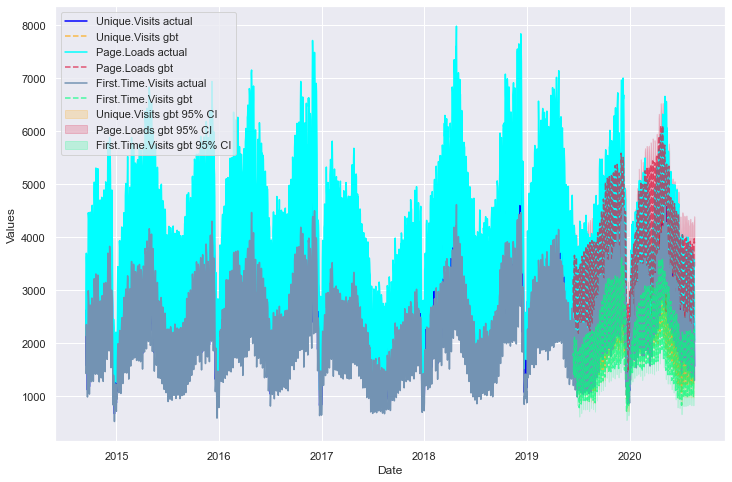

In [42]:
mvf.plot_test_set(ci=True,models='gbt')
plt.show()

In [43]:
mvf.set_best_model(determine_best_by='TestSetMAPE')

In [44]:
mvresults = mvf.export_model_summaries()
mvresults.columns

Index(['Series', 'ModelNickname', 'Estimator', 'Xvars', 'HyperParams', 'Lags',
       'Scaler', 'Observations', 'Tuned', 'DynamicallyTested', 'Integration',
       'TestSetLength', 'TestSetRMSE', 'TestSetMAPE', 'TestSetMAE',
       'TestSetR2', 'LastTestSetPrediction', 'LastTestSetActual', 'CILevel',
       'CIPlusMinus', 'InSampleRMSE', 'InSampleMAPE', 'InSampleMAE',
       'InSampleR2', 'ValidationSetLength', 'ValidationMetric',
       'ValidationMetricValue', 'LevelTestSetRMSE', 'LevelTestSetMAPE',
       'LevelTestSetMAE', 'LevelTestSetR2', 'OptimizedOn', 'MetricOptimized',
       'best_model'],
      dtype='object')

In [45]:
mvresults[['Series','ModelNickname','TestSetMAPE','TestSetR2','InSampleMAPE','InSampleR2','best_model']]

,Series,ModelNickname,TestSetMAPE,TestSetR2,InSampleMAPE,InSampleR2,best_model
0,Unique.Visits,mlr,0.131771,0.765529,0.060386,0.955522,True
1,Unique.Visits,gbt,0.151342,0.651063,0.036801,0.982360,False
2,Page.Loads,mlr,0.131613,0.747446,0.063934,0.949760,True
3,Page.Loads,gbt,0.134075,0.689671,0.039124,0.979638,False
4,First.Time.Visits,mlr,0.156312,0.698865,0.064223,0.953189,True
5,First.Time.Visits,gbt,0.174566,0.577685,0.037780,0.982150,False


In [46]:
mvf.export_validation_grid('gbt').sort_values('optimized_metric').head()

,learning_rate,n_estimators,subsample,max_depth,max_features,lags,validation_length,validation_metric,y1_metric,y2_metric,y3_metric,optimized_metric
4,0.10,300,1.00,3,0.5,7,60,rmse,218.593580,322.304828,203.882516,218.593580
16,0.01,400,1.00,10,0.5,"[1, 2, 3, 4, 5, 6, 7, 14, 21, 28, 35]",60,rmse,223.424553,341.945774,203.778184,223.424553
24,0.10,300,0.25,10,auto,"[1, 2, 3, 4, 5, 6, 7, 14, 21, 28, 35]",60,rmse,234.260859,359.713661,197.602910,234.260859
11,0.10,400,0.25,10,log2,7,60,rmse,236.504665,378.892878,237.692478,236.504665
32,0.01,400,0.25,10,auto,1,60,rmse,238.467042,388.898920,211.539513,238.467042


### RNN  
- Recurrent Neural Networks are considered a state-of-the-art model for forecasting time series. In scalecast, a fairly high amount of customization from Keras TensforFlow is available, with SimpleRNN, LSTM, and Dense cells all easily able to be specified. You will get the most out of neural networks by using a library built to dynamically build these models, such as Pytorch, Keras TF, or Darts. The advantage of applying these models in scalecast is that they are easy-to-apply and quickly see results.  
- We will apply all these models test-only to speed up processing time  
- This model cannot be tuned and does not accept variables other than the series' own history to make predictions  
- Dig deeper into RNN forecasting with [this notebook](https://scalecast-examples.readthedocs.io/en/latest/rnn/rnn.html) and [this notebook](https://scalecast-examples.readthedocs.io/en/latest/lstm/lstm.html)  

Epoch 1/150
31/31 [==============================] - 2s 31ms/step - loss: 0.3413 - val_loss: 0.2299
Epoch 2/150
31/31 [==============================] - 1s 26ms/step - loss: 0.1887 - val_loss: 0.1695
Epoch 3/150
31/31 [==============================] - 1s 27ms/step - loss: 0.1698 - val_loss: 0.1657
Epoch 4/150
31/31 [==============================] - 1s 27ms/step - loss: 0.1694 - val_loss: 0.1666
Epoch 5/150
31/31 [==============================] - 1s 30ms/step - loss: 0.1679 - val_loss: 0.1636
Epoch 6/150
31/31 [==============================] - 1s 30ms/step - loss: 0.1636 - val_loss: 0.1546
Epoch 7/150
31/31 [==============================] - 1s 26ms/step - loss: 0.1537 - val_loss: 0.1440
Epoch 8/150
31/31 [==============================] - 1s 26ms/step - loss: 0.1474 - val_loss: 0.1383
Epoch 9/150
31/31 [==============================] - 1s 27ms/step - loss: 0.1420 - val_loss: 0.1325
Epoch 10/150
31/31 [==============================] - 1s 25ms/step - loss: 0.1380 - val_loss: 0.1272

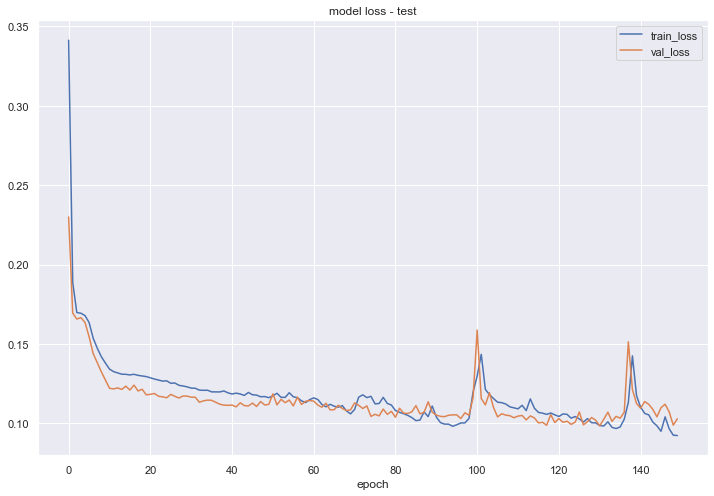

In [47]:
f.set_estimator('rnn')
f.manual_forecast(
    lags=75,
    layers_struct=[('SimpleRNN',{'units':100,'dropout':0})]*2 + [('Dense',{'units':10})]*2,
    epochs=150,
    random_seed=42,
    plot_loss_test=True,
    validation_split=0.2,
    call_me='rnn',
    verbose=1,
    test_only=True,
)

Epoch 1/150
31/31 [==============================] - 6s 100ms/step - loss: 0.3528 - val_loss: 0.2362
Epoch 2/150
31/31 [==============================] - 2s 78ms/step - loss: 0.1906 - val_loss: 0.1713
Epoch 3/150
31/31 [==============================] - 3s 89ms/step - loss: 0.1699 - val_loss: 0.1664
Epoch 4/150
31/31 [==============================] - 2s 78ms/step - loss: 0.1691 - val_loss: 0.1660
Epoch 5/150
31/31 [==============================] - 3s 88ms/step - loss: 0.1692 - val_loss: 0.1657
Epoch 6/150
31/31 [==============================] - 3s 99ms/step - loss: 0.1696 - val_loss: 0.1687
Epoch 7/150
31/31 [==============================] - 3s 96ms/step - loss: 0.1693 - val_loss: 0.1677
Epoch 8/150
31/31 [==============================] - 3s 83ms/step - loss: 0.1692 - val_loss: 0.1663
Epoch 9/150
31/31 [==============================] - 3s 88ms/step - loss: 0.1694 - val_loss: 0.1667
Epoch 10/150
31/31 [==============================] - 3s 87ms/step - loss: 0.1688 - val_loss: 0.166

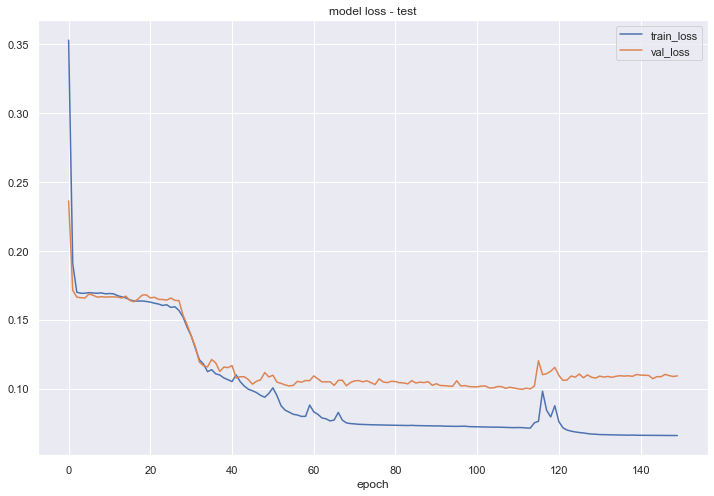

In [48]:
f.manual_forecast(
    lags=75,
    layers_struct=[('LSTM',{'units':100,'dropout':0})]*2 + [('Dense',{'units':10})]*2,
    epochs=150,
    random_seed=42,
    plot_loss_test=True,
    validation_split=0.2,
    call_me='lstm',
    verbose=1,
    test_only=True,
)

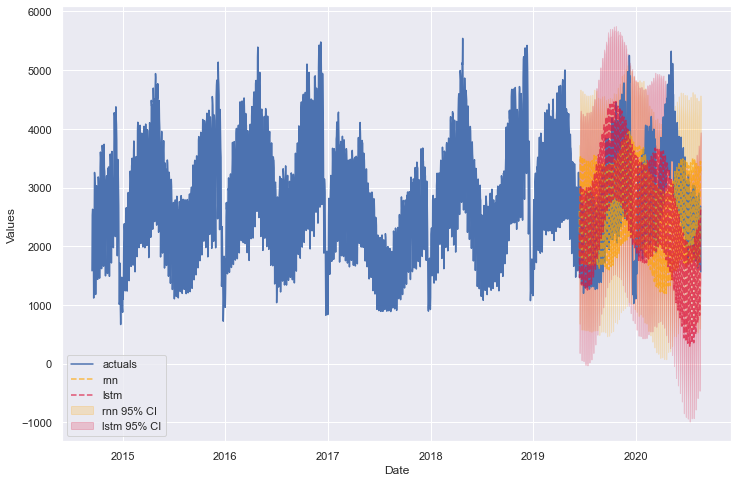

In [49]:
f.plot_test_set(models=['rnn','lstm'],order_by='TestSetMAPE',ci=True)
plt.show()

It doesn't appear as though either of these models outperformed the others, but there are reasons one of them could if we spent more time with it.

### HWES  
- Because this model can only capture one type of seasonality, there is reason to believe it won't perform well in this example  
- Dig deeper into Holt-Winters Exponential Smoothing forecasting with [this notebook](https://scalecast-examples.readthedocs.io/en/latest/hwes/hwes.html)  

In [50]:
f.set_estimator('hwes')
f.tune()
f.auto_forecast()

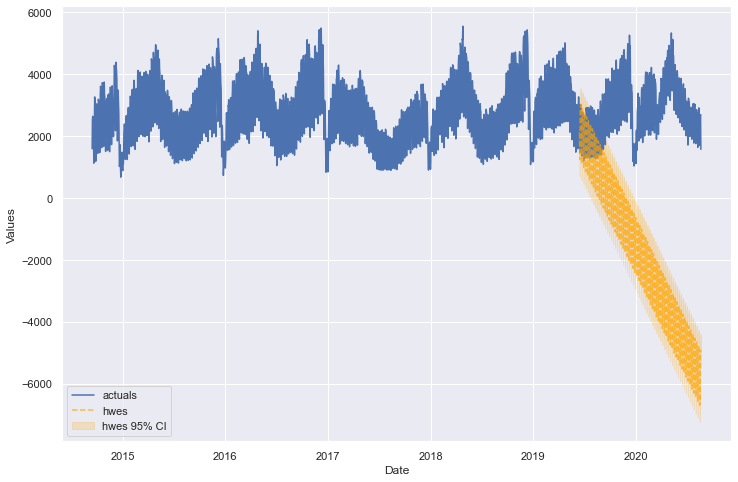

In [51]:
f.plot_test_set(models='hwes',order_by='TestSetMAPE',ci=True)
plt.show()

Very bad!!

In [52]:
results = f.export('model_summaries',determine_best_by='TestSetMAPE')
results[['ModelNickname','TestSetMAPE','TestSetR2','InSampleMAPE','InSampleR2','best_model']]

,ModelNickname,TestSetMAPE,TestSetR2,InSampleMAPE,InSampleR2,best_model
0,prophet,0.128508,0.756013,0.098131,0.887426,True
1,weighted,0.142030,0.673586,0.035223,0.984900,False
2,mlr,0.144739,0.711367,0.060099,0.955900,False
3,avg,0.148912,0.630121,0.058152,0.959802,False
4,xgboost,0.157852,0.568095,0.010725,0.998566,False
5,rnn,0.241404,0.111705,0.159263,0.719432,False
6,arima,0.242265,0.181024,0.091892,0.897641,False
7,lstm,0.259211,0.032797,0.170563,0.688076,False
8,silverkite,0.383909,-0.711844,0.119990,0.839140,False
9,hwes,1.556958,-32.594895,0.079407,0.931116,False


## Backtesting
- The prophet model looks like the best one, but is it really the best? Let's try backtesting our best three models to see which one comes through. Backtesting is the process of testing each model on the last 10 (or however many you specify) forecast horizons to see how that model actually would have performed on average had it been implemented.

In [53]:
f.backtest('prophet')
f.export_backtest_metrics('prophet')

,iter1,iter2,iter3,iter4,iter5,iter6,iter7,iter8,iter9,iter10,mean
RMSE,412.473953,382.365431,387.802034,399.641035,404.069679,399.737373,395.529231,406.330965,415.961357,427.941249,403.185231
MAE,323.067359,314.118812,318.60948,328.255336,330.734539,324.11259,318.601134,330.64553,341.688295,352.612398,328.244547
R2,0.288929,0.346749,0.331946,0.343282,0.339854,0.337574,0.362649,0.327201,0.300844,0.276586,0.325561
MAPE,0.13997,0.131309,0.132777,0.135652,0.13619,0.132021,0.129625,0.134346,0.139111,0.142493,0.135349


In [54]:
mvf.backtest('mlr')
mvf.export_backtest_metrics('mlr').loc[('Unique.Visits',)]

,iter1,iter2,iter3,iter4,iter5,iter6,iter7,iter8,iter9,iter10,mean
metric,,,,,,,,,,,
RMSE,422.69015,429.75562,375.913242,367.839058,320.171126,343.058952,392.274641,471.392019,474.850833,519.293156,411.723880
MAE,330.507292,339.669792,298.9375,293.179167,261.623958,287.685417,322.7375,370.716667,376.267708,413.617708,329.494271
R2,0.253269,0.174787,0.372279,0.443642,0.585531,0.512106,0.373095,0.094497,0.088865,-0.06523,0.283284
MAPE,0.142195,0.140376,0.123572,0.118509,0.106694,0.115219,0.126407,0.144132,0.147274,0.161605,0.132598


In [55]:
f.backtest('mlr')
f.export_backtest_metrics('mlr')

,iter1,iter2,iter3,iter4,iter5,iter6,iter7,iter8,iter9,iter10,mean
RMSE,455.616256,368.290183,407.076009,342.667518,328.843316,340.754787,365.764671,358.903871,374.879133,351.555854,369.435160
MAE,345.447331,305.028906,328.683333,287.801713,273.96875,289.360417,299.948958,295.14375,301.701302,294.641667,302.172613
R2,0.132402,0.393957,0.26389,0.517181,0.562774,0.518638,0.454965,0.475094,0.432128,0.51179,0.426282
MAPE,0.134841,0.113521,0.11992,0.107833,0.102324,0.107545,0.110002,0.108876,0.110135,0.109508,0.112450


It would appear from this comparison that the univariate MLR is actually the best! Let's see it plotted into the future!

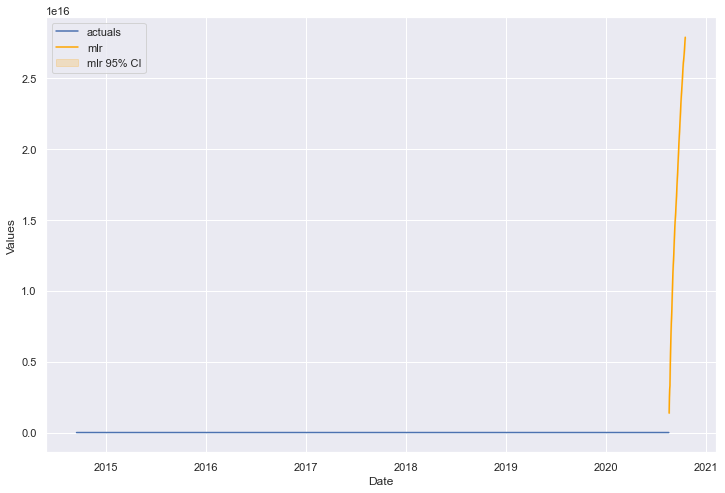

In [56]:
f.plot('mlr',ci=True)
plt.show()

Whoa! Something appears to have gone seriously wrong here. It's always important that your forecasts pass the eye test, and scalecast allows you to easily see such things. Let's default to the second-best model, prophet.

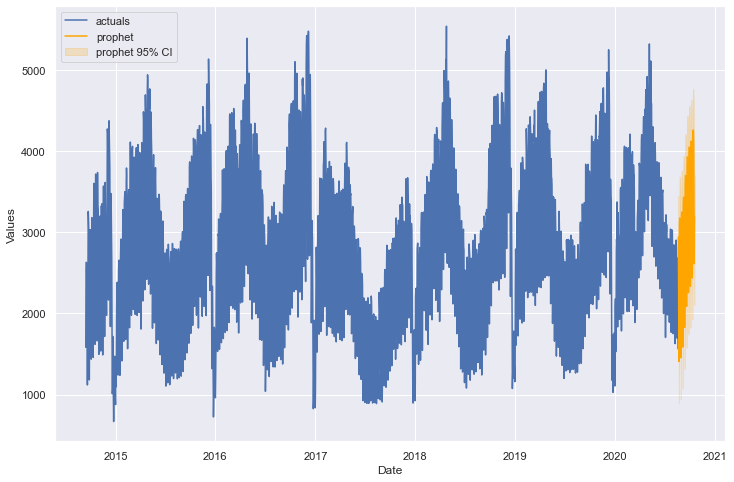

In [57]:
f.plot('prophet',ci=True)
plt.show()

Much more believable!